In [1]:
import sys
sys.path.append("..")

import numpy as np

from utils import params
from processing import postprocess
from train import skl_train
import visuals.plot as cplt

from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
from sklearn.preprocessing import binarize
from sklearn.externals import joblib

import matplotlib.pyplot as plt

# Evaluate Test Data

## Load Test Data 

Test Size: 970
-- All Values: 


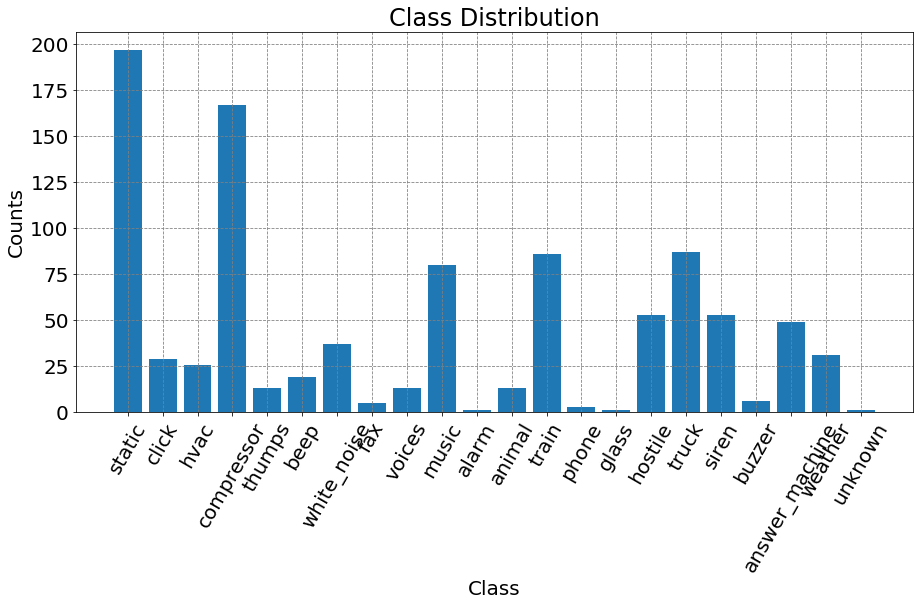

In [134]:
# LOAD TEST EMBEDDING DATA
#dfile = "./output/pandas/embeddings_16bit_aug_test2.pickle"
dfile = "../output/pandas/embeddings_16bit_test_04122018_aug_v2.pickle"
df_test,tdata = postprocess.load_pd_data(dfile,norm=False,nfeatures=640)

# PLOT DATA
print "Test Size: "+str(len(tdata))
print "-- All Values: "
cplt.plot_labels(df_test['labels'].get_values())

Class Ratio || Indist.: 0.50824742268, Dist: 0.49175257732
-- Binary Values


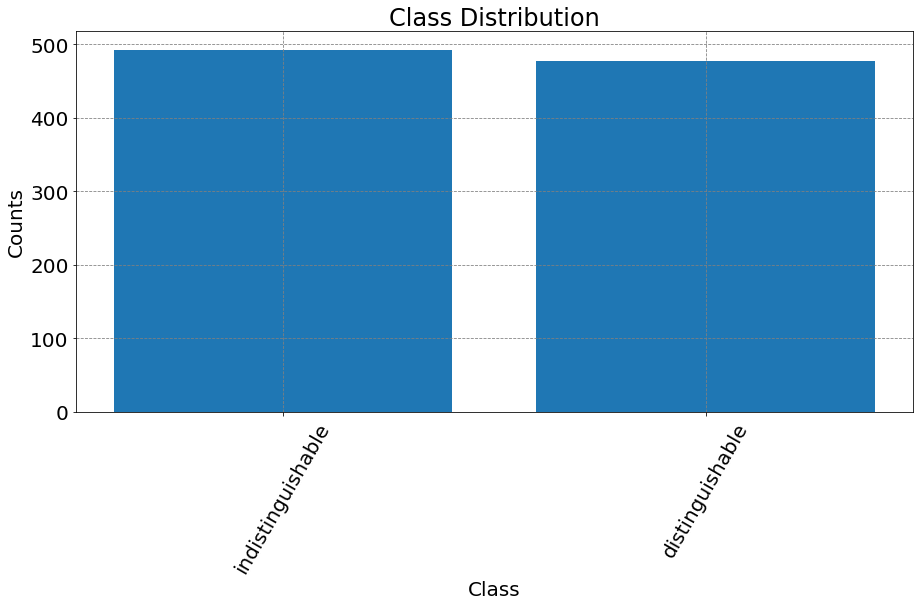

In [135]:
# LOAD TRAIN STATISTICS
#sfile = "./checkpoint/skl/train_stats_v3.npz"
sfile = "../checkpoint/skl/train_stats_binary_04122018_aug_v2.npz"
train_stats = np.load(sfile)

# CONVERT TO BINARY LABELS
orig = set(train_stats['breakdown'])
y_test = [0 if x in orig else 1 for x in df_test['labels'].get_values()]
#y_test = [1 if x==108 else 0 for x in df_test['labels'].get_values()]

print "Class Ratio || Indist.: "+str(np.count_nonzero(np.array(y_test)==0)/float(len(y_test)))+", Dist: "+str(np.count_nonzero(y_test)/float(len(y_test)))
print "-- Binary Values"
cplt.plot_labels(y_test,key={0:'indistinguishable',1:'distinguishable'})

In [136]:
# LOAD TRAINED MODEL
mfile = "../checkpoint/skl/xgb_binary_04122018_aug_v2.sav"
trained_model = joblib.load(mfile)

# NORAMLIZE DATA
X_test = (tdata-train_stats['train_mean'])/train_stats['train_std']

<type 'numpy.ndarray'>
Threshold: 0.09
Accuracy: 0.6927835051546392
Recall: 0.8574423480083857
Background Screened: 0.5334685598377282
Hostile Missed: 0.14255765199161424
Confusion matrix, without normalization
[[263 230]
 [ 68 409]]


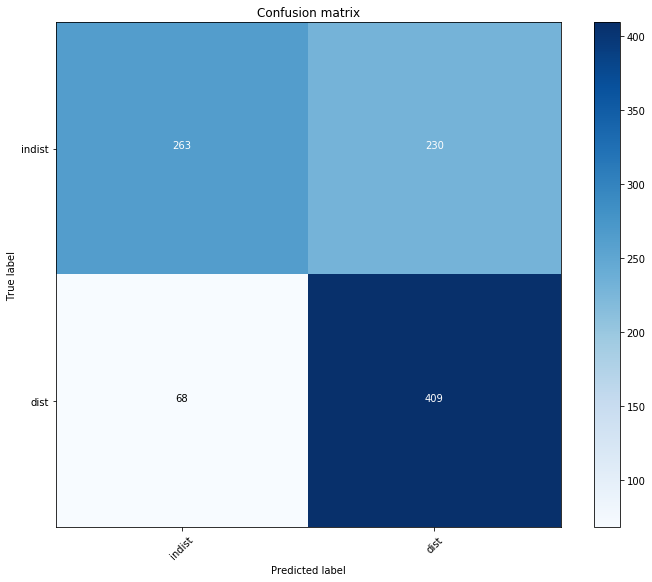

In [162]:
import pandas as pd
# PREDICT TEST CLASSES
thresh=0.09
y_proba = trained_model.predict_proba(X_test)
y_proba_pred = binarize(y_proba,thresh)[:,1]
names = ['indistinguishable' if y_proba_pred[x]<1 else 'distinguishable' for x in range(len(y_proba_pred))]
print type(y_proba)
df_test['raw_preds'] = pd.Series(y_proba.tolist(),index=df_test.index)
df_test['ground_truth'] = pd.Series(y_test,index=df_test.index)
df_test['predicted_class'] = pd.Series(names,index=df_test.index)

# PLOT CONFUSION MATRIX
cm_res = confusion_matrix(y_test,y_proba_pred)
print "Threshold: "+str(thresh)
print "Accuracy: "+str(accuracy_score(y_test,y_proba_pred))
print "Recall: "+str(recall_score(y_test,y_proba_pred))
print "Background Screened: "+str(cm_res[0,0]/float(cm_res[0,0]+cm_res[0,1]))
print "Hostile Missed: "+str(cm_res[1,0]/float(cm_res[1,0]+cm_res[1,1]))
cplt.plot_confusion_matrix(cm_res,['indist','dist'])

In [147]:
df_test[['names','raw_preds','ground_truth','predicted_class']].to_csv("./ground_truth_04122018_v2_aug.csv")

# Misclassification Analysis 

## Overview 

-- False Negatives: 


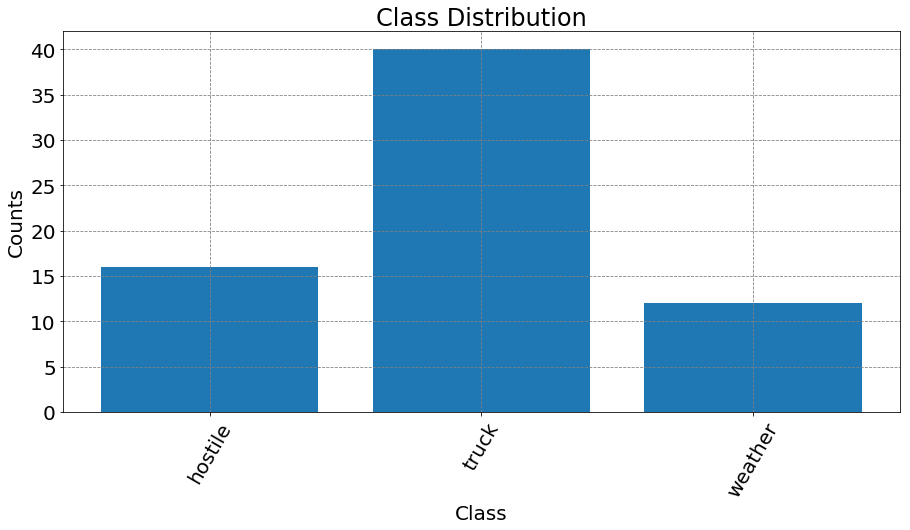

-- False Positives: 


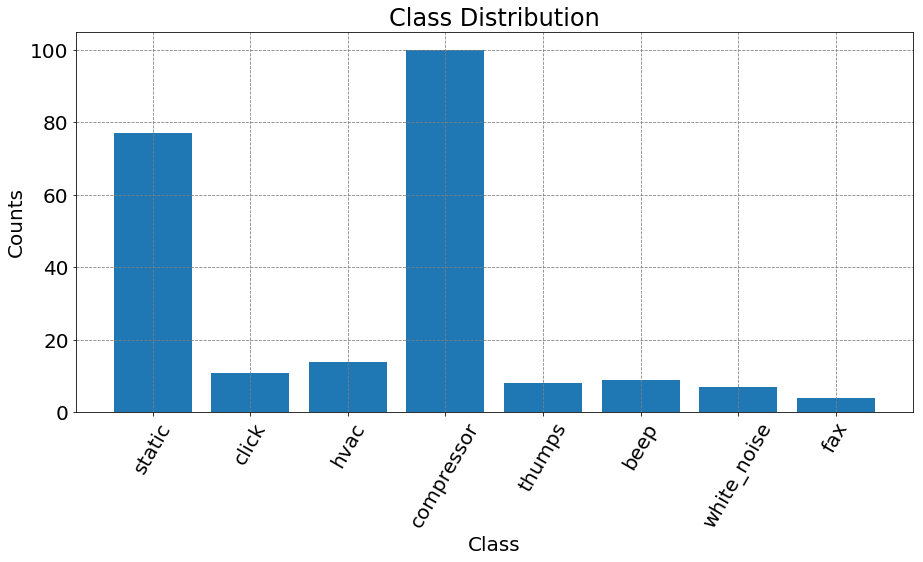

In [163]:
# FILTER DATA
df_test['preds'] = y_proba_pred
df_FN = df_test[(~df_test['labels'].isin(orig))&(df_test['preds']==0)]
df_FP = df_test[(df_test['labels'].isin(orig))&(df_test['preds']==1)]

print "-- False Negatives: "
cplt.plot_labels(df_FN['labels'].get_values())

print "-- False Positives: "
cplt.plot_labels(df_FP['labels'].get_values())

## Signal To Noise Analysis 

In [70]:
from models.research.audioset.vggish_input  import wavfile_to_examples, waveform_to_examples
from scipy.signal import butter
from scipy.signal import lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def threshold(signal,dmax,thresh=1.0):
    dthresh = thresh*dmax
    alpha = dthresh/(np.exp(1.0)-1.0)
    return np.array([np.sign(x)*alpha*(np.exp(np.abs(x)/dthresh)-1) if np.abs(x) <dthresh else x for x in list(signal)])

def sigmoid(signal):
    return 1 / (1 + np.exp(-signal))

def plot_mel_grams_processed(wfile):
    rate,data = wavfile.read(wfile)
    #btf = butter_bandpass_filter(data,1000,8000,rate)
    bmax = max(np.amax(data),np.abs(np.amin(data)))
    thresh = threshold(data,bmax)
    mel = waveform_to_examples(thresh,rate)
    
    cmax = np.amax(mel)
    plt.figure(figsize=(15,7))
    plt.title("Mel Spectrograms")
    for i in range(mel.shape[0]):
        plt.subplot(1, 5, i+1)
        plt.imshow(np.rot90(mel[i],k=1))
    return
    
def plot_mel_grams(wfile):
    mel = wavfile_to_examples(wfile)
    cmax = np.amax(mel)
    plt.figure(figsize=(15,7))
    plt.title("Mel Spectrograms")
    for i in range(mel.shape[0]):
        plt.subplot(1, 5, i+1)
        plt.imshow(np.rot90(mel[i],k=1))
    return

def plot_signal(wfile,process=True):
    rate,data = wavfile.read(wfile)
    cmax = max(np.amax(data),np.abs(np.amin(data)))
    xs = 5*np.array(range(len(data)))/float(len(data))
    plt.figure(figsize=(15,7))
    plt.plot(xs,data,label='raw')
    plt.plot(xs,threshold(data,cmax),label='compressed')
    if process:
        pre_emph = np.append(data[0], data[1:] - 0.97 * data[:-1])
        btf = butter_bandpass_filter(data,2000,6000,rate)
        #plt.plot(xs,pre_emph/np.amax(pre_emph),label='pre-emphasis')
        plt.plot(xs,btf/np.amax(btf),label='butter-bandpass')
    plt.axis([0,max(xs),-cmax,cmax])
    plt.legend()
    return

def plot_signal_noise(wfile,factor=0.5):
    rate,data = wavfile.read(wfile)
    cmax = max(np.amax(data),np.abs(np.amin(data)))
    xs = 5*np.array(range(len(data)))/float(len(data))
    noise = np.random.normal(np.mean(data),factor*np.std(data),len(data))
    plt.figure(figsize=(15,7))
    plt.plot(xs,data+noise,label='raw')
    plt.axis([0,max(xs),-cmax,cmax])
    plt.legend()
    return
    
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def snr(file):
    data = wavfile.read(file)[1]
    norm = data / (max(np.amax(data), -1 * np.amin(data)))
    return signaltonoise(norm)

## False Negative 

In [54]:
from scipy.io import wavfile
import IPython.display as ipd

# FALSE NEGATIVE HOSTILE
df_FN_hostile = df_test[(df_test['labels']>10)&(df_test['preds']==0)&(df_test['names']=='hostile')]
hfiles = df_FN_hostile.index.get_values()

Signal To Noise: -0.9846975671718218


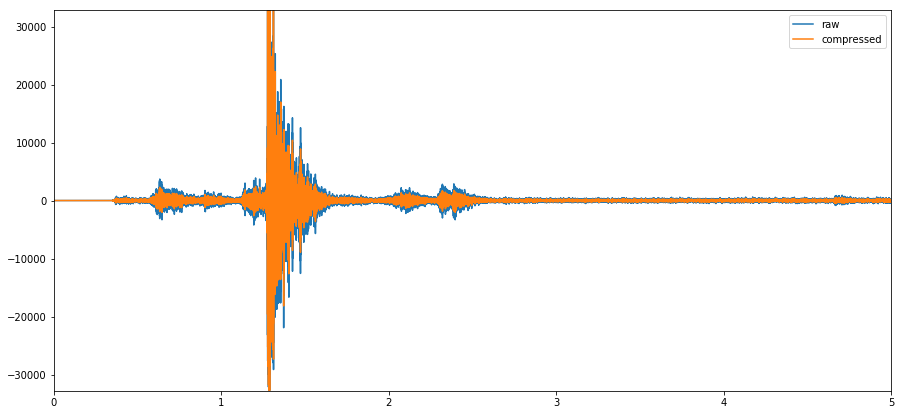

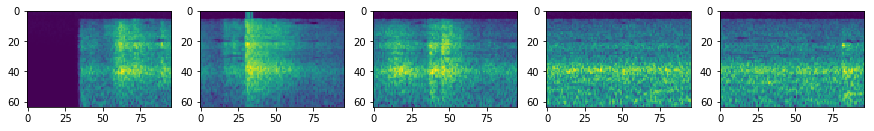

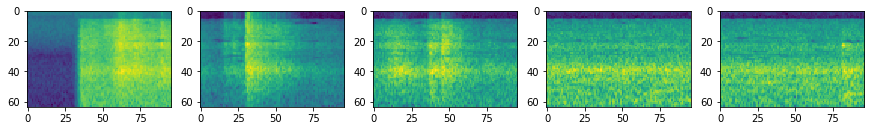

In [55]:
mfile = hfiles[0]
print "Signal To Noise: "+str(snr(mfile))
plot_signal(mfile,process=False)
plot_mel_grams(mfile)
plot_mel_grams_processed(mfile)
ipd.Audio(mfile)

Signal To Noise: -0.987614114093831


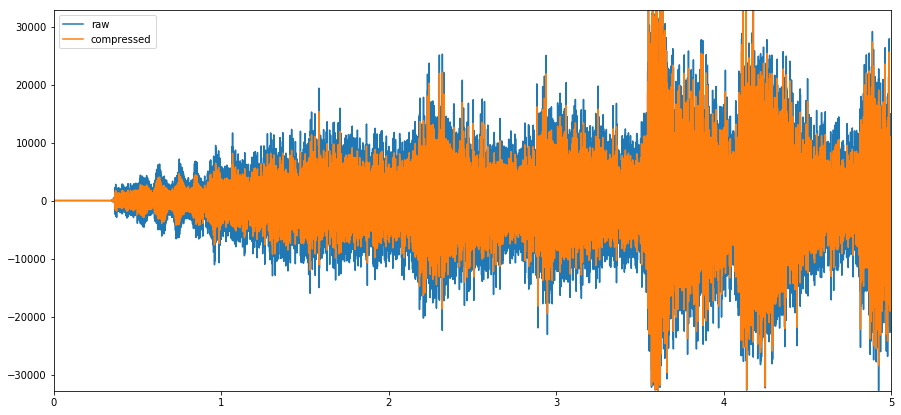

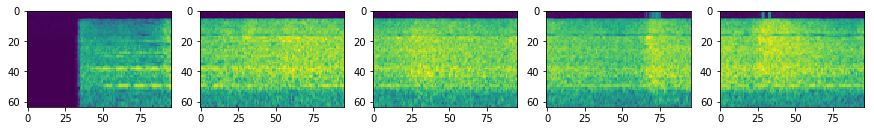

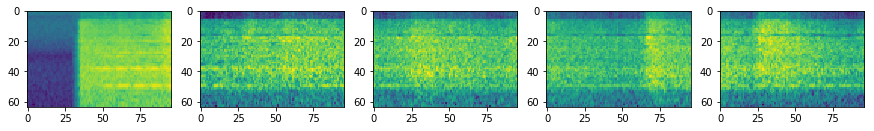

In [56]:
mfile = hfiles[4]
print "Signal To Noise: "+str(snr(mfile))
plot_signal(mfile,process=False)
plot_mel_grams(mfile)
plot_mel_grams_processed(mfile)
ipd.Audio(mfile)

Signal To Noise: -1.0787765097883637


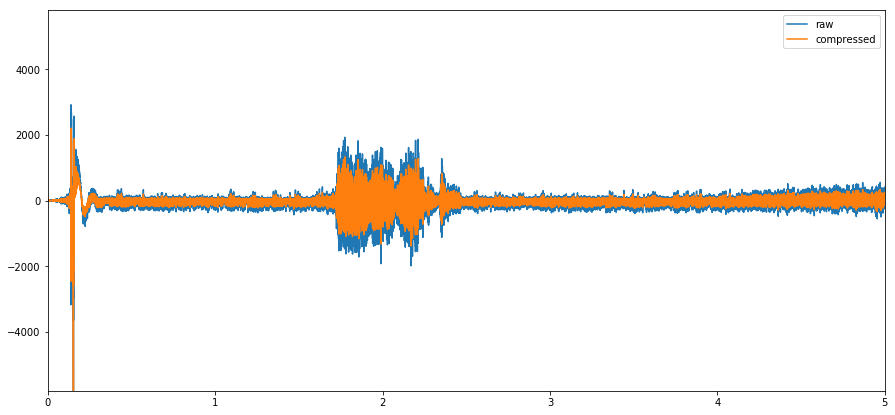

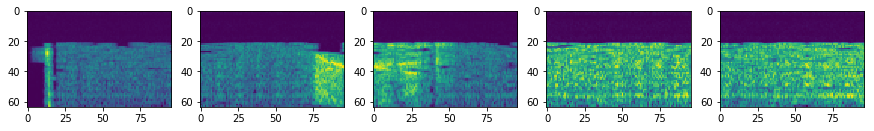

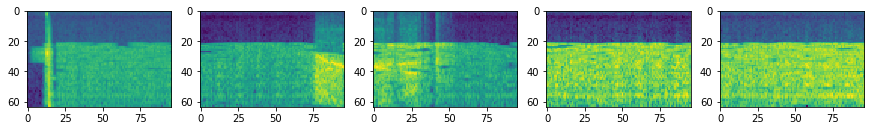

In [57]:
mfile = hfiles[11]
print "Signal To Noise: "+str(snr(mfile))
plot_signal(mfile,process=False)
plot_mel_grams(mfile)
plot_mel_grams_processed(mfile)
ipd.Audio(mfile)

## True Positives 

In [58]:
# FALSE NEGATIVE HOSTILE
df_TP_hostile = df_test[(df_test['labels']>10)&(df_test['preds']==1)&(df_test['names']=='hostile')]
hfilest = df_TP_hostile.index.get_values()

Signal To Noise: -1.5110275603928691


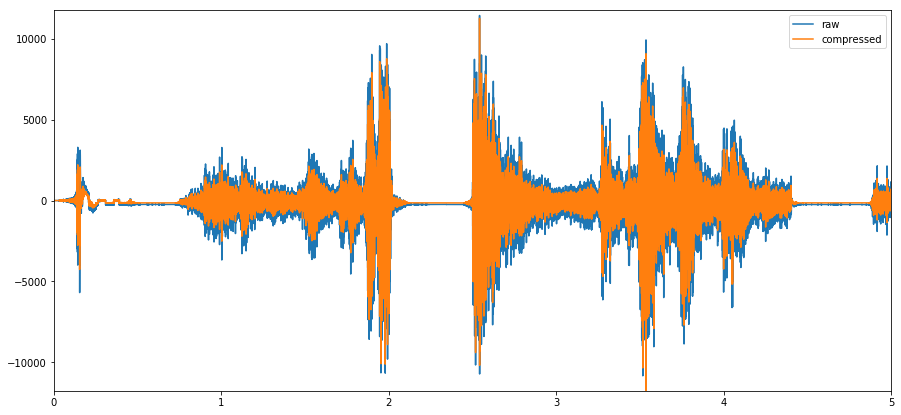

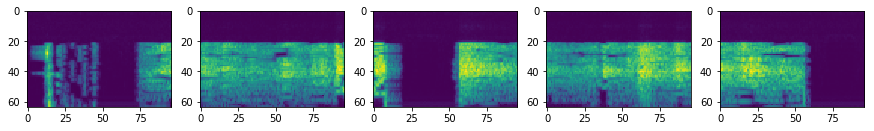

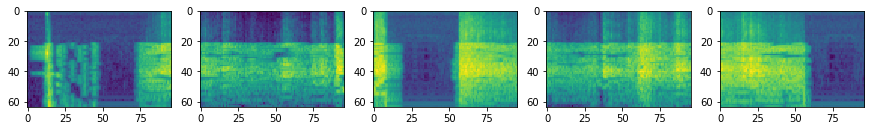

In [59]:
mfile = hfilest[0]
print "Signal To Noise: "+str(snr(mfile))
plot_signal(mfile,process=False)
plot_mel_grams(mfile)
plot_mel_grams_processed(mfile)
ipd.Audio(mfile)

Signal To Noise: -0.9854661493075361


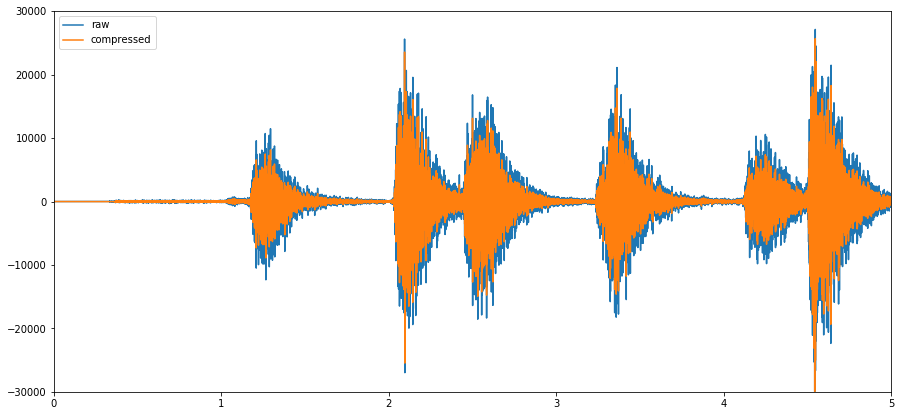

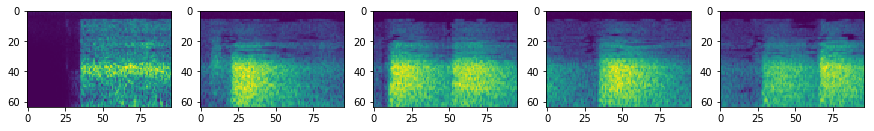

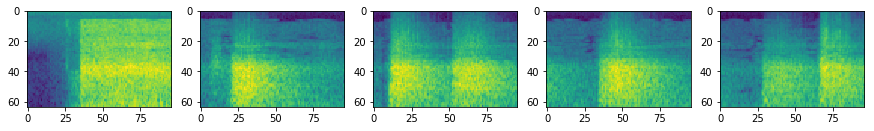

In [60]:
mfile = hfilest[4]
print "Signal To Noise: "+str(snr(mfile))
plot_signal(mfile,process=False)
plot_mel_grams(mfile)
plot_mel_grams_processed(mfile)
ipd.Audio(mfile)

Signal To Noise: -0.9842152674100094


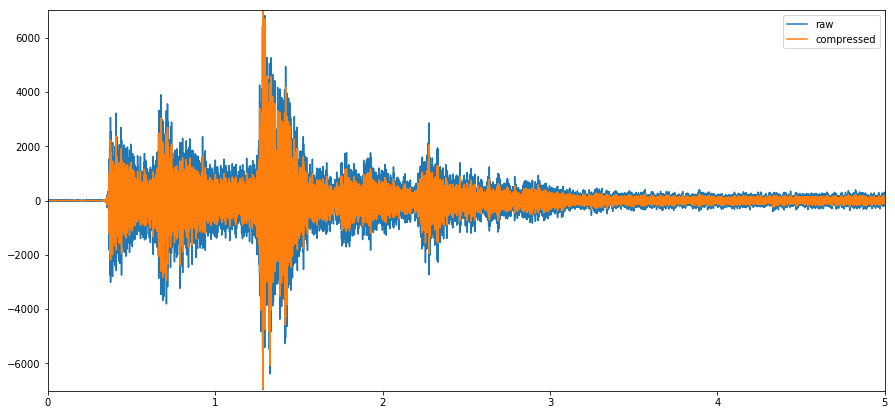

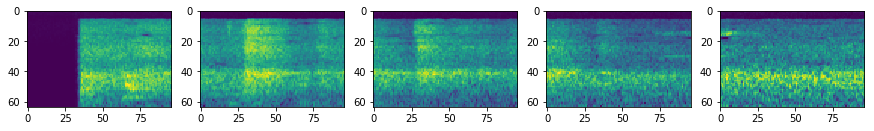

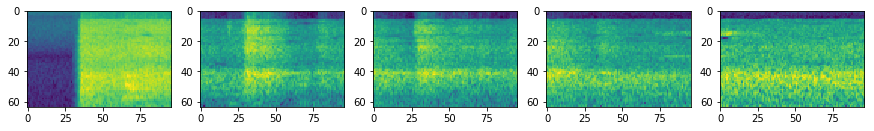

In [61]:
mfile = hfilest[11]
print "Signal To Noise: "+str(snr(mfile))
plot_signal(mfile,process=False)
plot_mel_grams(mfile)
plot_mel_grams_processed(mfile)
ipd.Audio(mfile)

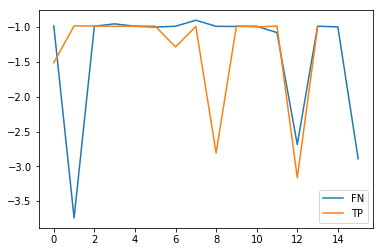

In [63]:
s2n_FN = [snr(x) for x in hfiles]
s2n_TP = [snr(x) for x in hfilest]

plt.plot(s2n_FN,label='FN')
plt.plot(s2n_TP,label='TP')
plt.legend()

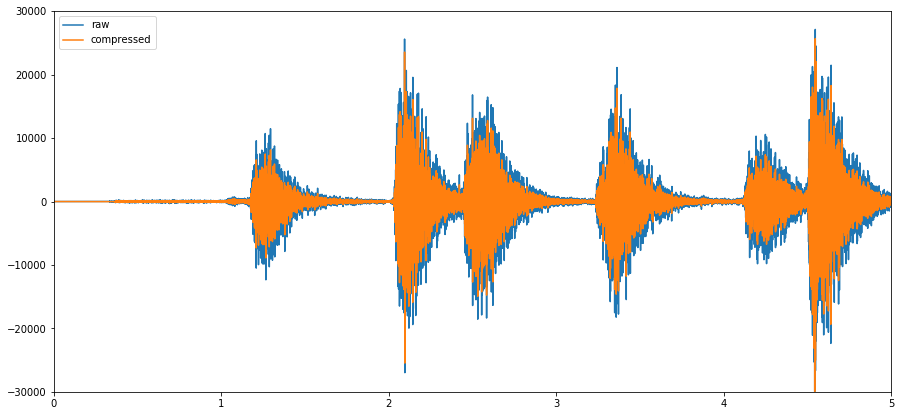

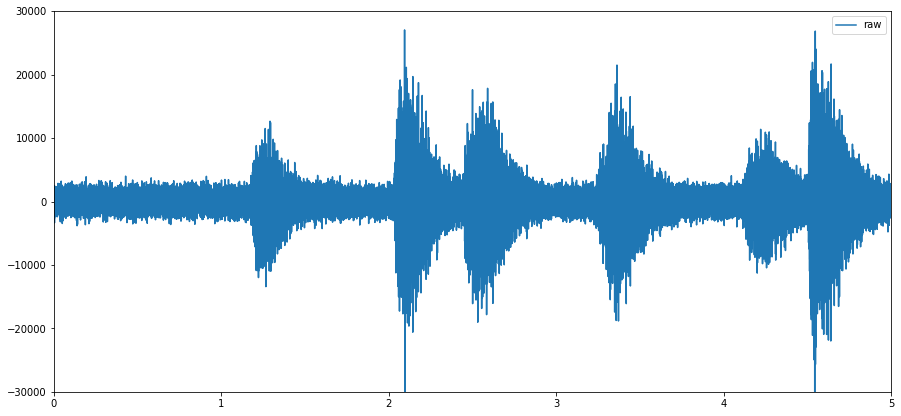

In [80]:
mfile = hfilest[4]
plot_signal(mfile,process=False)
plot_signal_noise(mfile,factor=0.35)

# Webservice Test

In [29]:
import requests
from scipy.io import wavfile
import json
from utils import postprocess

def generate_predictions(test_files,pred_url = "http://localhost:5000/sonitrol/predict"):
    preds = []
    for test in test_files:
        rate,wave = wavfile.read(test)
        payload = {'rate':rate,'wave':wave.tolist()}
        res = requests.post(pred_url,data=json.dumps(payload))
        print res

In [30]:
dfile = "./output/pandas/embeddings_16bit_aug_test_v3.pickle"
rdf,rdata = postprocess.load_pd_data(dfile,norm=False,nfeatures=640)
generate_predictions(rdf.index.get_values())

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /sonitrol/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fec9dc39d10>: Failed to establish a new connection: [Errno 111] Connection refused',))